In [20]:
import pandas as pd

In [21]:
ls -arlt ../datasets/

total 0
drwxr-xr-x   3 lisabang  staff   96 Jul  8 01:30 ./
drwxr-xr-x   4 lisabang  staff  128 Jul  8 01:30 liuthyroid/
drwxr-xr-x  12 lisabang  staff  384 Jul  8 01:30 ../


In [22]:
yt=pd.read_csv("../datasets/liuthyroid/liu_thrb_orig.csv", index_col=0)
xt=pd.read_csv("../datasets/liuthyroid/liu_thrb_lb_dragon6.txt", sep="\t", index_col=0)

In [39]:
%%latex
$$Y_i = \beta_{i0} + \beta_{i 1} X_1 + \beta_{i2} X_2 + \ldots + \beta_{ip}X_p +\epsilon_i$$

<IPython.core.display.Latex object>

In [23]:
yt.head()

,GATS1e,EEig08x,EEig07d,GGI6,R6v+,H-051,Y Exp.,Y-Pred,Seta
ID,,,,,,,,,
1,0.722,2.372,1.846,0.771,0.042,0,9.59,9.84,1
2,0.710,1.869,1.846,0.567,0.046,2,10.32,10.43,1
3,0.709,2.372,2.145,0.771,0.031,0,9.96,10.62,1
4,0.705,1.984,1.846,0.690,0.049,2,10.72,10.47,1
5,0.732,2.334,2.145,0.690,0.033,2,10.60,9.56,1


In [24]:
yt=yt["Y Exp."].dropna()
xt=xt.dropna()
xt=xt.drop(columns=["NAME"])

In [26]:
xt.head()

,MW,AMW,Sv,Mv,Me,Mp,Mi,nBM,RBN,RBF,...,DLS_07,DLS_cons,LLS_01,LLS_02,CMC-80,Inflammat-80,Psychotic-80,Hypertens-80,Neoplastic-80,Infective-80
No.,,,,,,,,,,,,,,,,,,,,,
1,650.98,18.599,26.519,0.758,1.023,0.889,1.097,13,5,0.139,...,1.0,0.65,0.17,0.88,0,0,0,0,0,0
3,567.18,12.890,29.782,0.677,1.009,0.767,1.112,13,6,0.133,...,1.0,0.88,0.17,0.88,0,0,0,0,0,0
4,635.96,19.272,25.497,0.773,1.021,0.913,1.088,13,5,0.147,...,1.0,0.61,0.17,0.75,0,0,0,0,0,0
5,458.16,10.909,28.178,0.671,1.014,0.718,1.111,13,6,0.140,...,1.0,0.87,0.17,0.88,0,0,0,0,0,0
6,430.10,11.947,25.124,0.698,1.023,0.739,1.107,13,4,0.108,...,1.0,0.87,0.17,1.00,1,0,0,0,0,0


In [27]:
!pip install matplotlib

In [28]:
import numpy as np
import sklearn.model_selection as skms
import matplotlib.pyplot as plt

def mlr(x_of_trainingset, y_actual):
    columnnames = list(x_of_trainingset.columns.values)
    npones = np.ones(len(y_actual), float)
    A_sl = x_of_trainingset.as_matrix()
    A = np.column_stack([A_sl, npones])
    lstsq, residuals, rank, something = np.linalg.lstsq(A, y_actual)
    degfreedom = y_actual.size - 1

    r2 = 1 - residuals / (y_actual.size * y_actual.var())
    r2adj = 1 - (((1 - r2) * degfreedom) / (y_actual.size - rank - 2))
    RMSE = np.sqrt(1 - r2) * np.std(y_actual)

    # fitness=collections.namedtuple([x_of_trainingset],[r2,r2adj,RMSE])
    return lstsq, rank, r2, r2adj, RMSE

    # y_predicted=(lstsq[0]*liu_train(0))+(lstsq[1]*liu_train(1))+(lstsq[2])+(lstsq[3])+(lstsq[4])+(lstsq[5])+lstsq[6]
    # print "y-predicted:"
    # print y_predicted

from sklearn.linear_model import LinearRegression

def mlr_r2(X,y):
    model = LinearRegression()
    model.fit(X, y)
    # compute with formulas from the theory
    yhat = model.predict(X)
    SS_Residual = sum((y-yhat)**2)
    SS_Total = sum((y-np.mean(y))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
    return r_squared, adjusted_r_squared

def mlr_r2_2(X,y):
    model = LinearRegression()
    model.fit(X, y)
    # compute with sklearn linear_model, although could not find any function to compute adjusted-r-square directly from documentation
    return model.score(X, y), 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)

def mlrr(x_of_trainingset, y_actual):
    #usethis
    npones = np.ones(len(x_of_trainingset), float)
    A_sl = x_of_trainingset
    A = np.column_stack([A_sl, npones])
    lstsq, residuals, rank, something = np.linalg.lstsq(A, y_actual)
    return lstsq, residuals
def pmlr(x_of_trainingset, y_actual):
    npones = np.ones(len(y_actual), float)
    A = np.column_stack([x_of_trainingset, npones])
    lstsq = np.dot(np.linalg.pinv(A), y_actual)
    return lstsq


def kfoldmlr(xi, yi, **kwargs):
    '''gives the y-hats for a q2LOO calculation'''
    x = xi.values
    y = yi.values
    nfolds=kwargs["nfolds"]
    mean=kwargs["mean"]
    kf = skms.KFold(n_splits=nfolds)  # indices=None, shuffle=False, random_state=None)
    y_hats = []
    print(kf)
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        coefficients = mlrr(x_train, y_train)[0]
        resids = mlrr(x_train, y_train)[1]
        y_hats.append(resids)
    # for e in y_hats:
    #    cleanyhats.append(float(e))
    stack = np.asarray(y_hats)
    if mean==True:
        return np.mean(stack)
    else:
        return stack


def kfoldmlrplot(xi, yi, **kwargs):
    '''gives the y-hats for a q2LOO calculation'''
    x = xi.values
    y = yi.values
    nfolds=kwargs["nfolds"]
    kf = skms.KFold(n_splits=nfolds)  # indices=None, shuffle=False, random_state=None)
    y_hats = []
    print(kf)
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        coefficients = mlrr(x_train, y_train)[0]
        resids = mlrr(x_train, y_train)[1]
        plt.plot(x_train, y_train, 'o', label='Original data', markersize=5)
        plt.plot(x_train, coefficients[0]*x_train + coefficients[1], 'r', label='Fitted line')
        plt.legend()
        plt.show()


In [29]:
xt.head()

,MW,AMW,Sv,Mv,Me,Mp,Mi,nBM,RBN,RBF,...,DLS_07,DLS_cons,LLS_01,LLS_02,CMC-80,Inflammat-80,Psychotic-80,Hypertens-80,Neoplastic-80,Infective-80
No.,,,,,,,,,,,,,,,,,,,,,
1,650.98,18.599,26.519,0.758,1.023,0.889,1.097,13,5,0.139,...,1.0,0.65,0.17,0.88,0,0,0,0,0,0
3,567.18,12.890,29.782,0.677,1.009,0.767,1.112,13,6,0.133,...,1.0,0.88,0.17,0.88,0,0,0,0,0,0
4,635.96,19.272,25.497,0.773,1.021,0.913,1.088,13,5,0.147,...,1.0,0.61,0.17,0.75,0,0,0,0,0,0
5,458.16,10.909,28.178,0.671,1.014,0.718,1.111,13,6,0.140,...,1.0,0.87,0.17,0.88,0,0,0,0,0,0
6,430.10,11.947,25.124,0.698,1.023,0.739,1.107,13,4,0.108,...,1.0,0.87,0.17,1.00,1,0,0,0,0,0


In [30]:
xt.head()

,MW,AMW,Sv,Mv,Me,Mp,Mi,nBM,RBN,RBF,...,DLS_07,DLS_cons,LLS_01,LLS_02,CMC-80,Inflammat-80,Psychotic-80,Hypertens-80,Neoplastic-80,Infective-80
No.,,,,,,,,,,,,,,,,,,,,,
1,650.98,18.599,26.519,0.758,1.023,0.889,1.097,13,5,0.139,...,1.0,0.65,0.17,0.88,0,0,0,0,0,0
3,567.18,12.890,29.782,0.677,1.009,0.767,1.112,13,6,0.133,...,1.0,0.88,0.17,0.88,0,0,0,0,0,0
4,635.96,19.272,25.497,0.773,1.021,0.913,1.088,13,5,0.147,...,1.0,0.61,0.17,0.75,0,0,0,0,0,0
5,458.16,10.909,28.178,0.671,1.014,0.718,1.111,13,6,0.140,...,1.0,0.87,0.17,0.88,0,0,0,0,0,0
6,430.10,11.947,25.124,0.698,1.023,0.739,1.107,13,4,0.108,...,1.0,0.87,0.17,1.00,1,0,0,0,0,0


In [31]:
xt.shape

(85, 1176)

In [32]:
yt.shape

(85,)

In [34]:
mlrr(xt, yt)

/Users/lisabang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


(array([-0.01674604,  0.00391377, -0.00384408, ..., -0.00208741,
         0.00114585,  0.00030916]), array([], dtype=float64))

In [271]:
#xt=xt.loc[yt.index]

In [272]:
#yt=pd.DataFrame(yt)

In [273]:
xt.head()

,MW,AMW,Sv,Mv,Me,Mp,Mi,nBM,RBN,RBF,...,DLS_07,DLS_cons,LLS_01,LLS_02,CMC-80,Inflammat-80,Psychotic-80,Hypertens-80,Neoplastic-80,Infective-80
No.,,,,,,,,,,,,,,,,,,,,,
1,650.98,18.599,26.519,0.758,1.023,0.889,1.097,13,5,0.139,...,1.0,0.65,0.17,0.88,0,0,0,0,0,0
3,567.18,12.890,29.782,0.677,1.009,0.767,1.112,13,6,0.133,...,1.0,0.88,0.17,0.88,0,0,0,0,0,0
4,635.96,19.272,25.497,0.773,1.021,0.913,1.088,13,5,0.147,...,1.0,0.61,0.17,0.75,0,0,0,0,0,0
5,458.16,10.909,28.178,0.671,1.014,0.718,1.111,13,6,0.140,...,1.0,0.87,0.17,0.88,0,0,0,0,0,0
6,430.10,11.947,25.124,0.698,1.023,0.739,1.107,13,4,0.108,...,1.0,0.87,0.17,1.00,1,0,0,0,0,0


In [274]:
#%timeit pmlr(xt,yt)

In [275]:
#%timeit mlrr(xt,yt)

In [278]:
kfoldmlr(xt[["MW", "nBM", "LLS_02", "Sv"]],yt, nfolds=5, mean=False)

KFold(n_splits=5, random_state=None, shuffle=False)


/home/lisa/PycharmProjects/deapVS/venv/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


array([[36.28588632],
       [87.01518463],
       [93.20532179],
       [92.97481114],
       [84.83665839]])

In [277]:
kfoldmlr(xt[["MW", "nBM", "LLS_02", "Sv"]],yt, nfolds=5, mean=True)

KFold(n_splits=5, random_state=None, shuffle=False)


/home/lisa/PycharmProjects/deapVS/venv/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


78.86357245125437

In [280]:
kfoldmlr(xt[["MW", "nBM", "LLS_02", "Sv"]],yt, nfolds=85, mean=True)

KFold(n_splits=85, random_state=None, shuffle=False)


/home/lisa/PycharmProjects/deapVS/venv/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


103.54935038946525

In [281]:
kfoldmlr(xt[["MW", "nBM", "LLS_02", "Sv"]],yt, nfolds=17, mean=True)

KFold(n_splits=17, random_state=None, shuffle=False)


/home/lisa/PycharmProjects/deapVS/venv/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


97.13213851267417

KFold(n_splits=5, random_state=None, shuffle=False)


/home/lisa/PycharmProjects/deapVS/venv/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


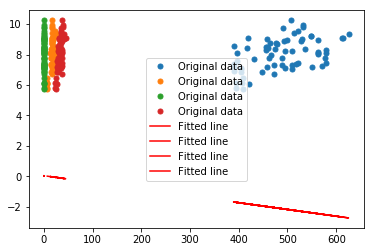

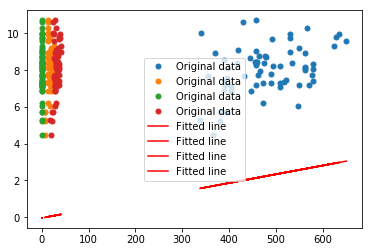

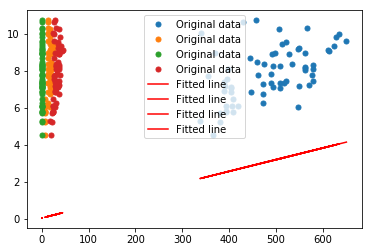

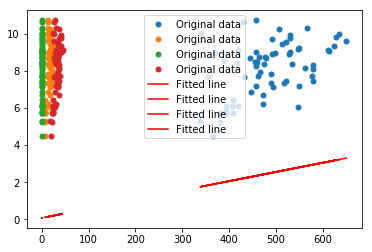

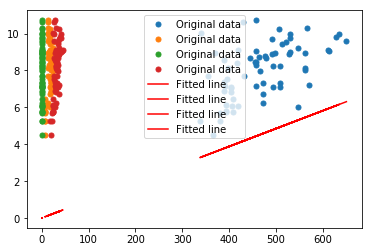

In [264]:
kfoldmlrplot(xt[["MW", "nBM", "LLS_02", "Sv"]],yt, nfolds=5)